In [101]:
import pandas as pd
import pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import matplotlib.pyplot as plt
import networkx as nx
import pylab as plt
import itertools
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [74]:
data = pd.read_csv("./london_merged.csv")
data["time"] = pd.to_datetime(data["timestamp"]).dt.time.astype(str).str.slice(0,2).astype(int)
data = data.drop("timestamp", axis = 1)

# data = data[data['cnt'] < 5000]
data = data[data['time'] > 6]

data['is_weekend'] = data['is_weekend'].map({1: "yes", 0: "no"})
data['is_holiday'] = data['is_holiday'].map({1: "yes", 0: "no"})
data['weather'] = data['weather_code'].map({
    1: "clear", 
    2: "few_clouds", 
    3: "broken_clouds", 
    4: "cloudy", 
    7: "rain", 
    10: "thunderstorm",
    26: "snowfall",
    94: "freezing_fog"
})
data['season'] = data['season'].map({
    0: "spring",
    1: "summer",
    2: "fall",
    3: "winter"
})
data["wind"] = data['wind_speed']
data = data.drop('wind_speed', axis = 1)
data["temperature"] = data["t1"]
data = data.drop("t1", axis = 1)
data["temperature_feels"] = data["t2"]
data = data.drop("t2", axis = 1)
data = data.drop("weather_code", axis = 1)

data.head()


,cnt,hum,is_holiday,is_weekend,season,time,weather,wind,temperature,temperature_feels
7,75,100.0,no,yes,winter,7,cloudy,7.0,1.0,-1.0
8,131,96.5,no,yes,winter,8,cloudy,8.0,1.5,-1.0
9,301,100.0,no,yes,winter,9,broken_clouds,9.0,2.0,-0.5
10,528,93.0,no,yes,winter,10,broken_clouds,12.0,3.0,-0.5
11,727,100.0,no,yes,winter,11,broken_clouds,12.0,2.0,-1.5


In [75]:

data['temperature'] = pd.cut(data['temperature'], bins=4, labels=[0, 1, 2, 3])
data['temperature_feels'] = pd.cut(data['temperature_feels'], bins=4, labels=[0, 1, 2, 3])
data['time'] = pd.cut(data['time'], bins=4, labels=["morning", "afternoon", "evening", "night"])
data['hum'] = pd.cut(data['hum'], bins=4, labels=[0, 1, 2, 3])
data['wind'] = pd.cut(data['wind'], bins=2, labels=["yes", "no"])
data['cnt'] = pd.qcut(data['cnt'], q=8, labels=[0, 1, 2, 3, 4, 5, 6, 7])

In [76]:
data["temperature_feels"].unique()

[0, 1, 2, 3]
Categories (4, int64): [0 < 1 < 2 < 3]

StopIteration: 

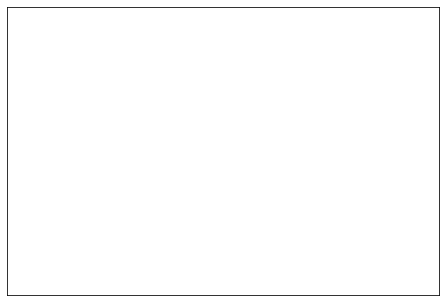

In [110]:
network = BayesianNetwork()
network.add_nodes_from(["cnt", "temperature", "wind", "weather", "is_weekend", "season", "time", "temperature_feels", "hum", "is_holiday"])

network.add_edge("season", "weather")
network.add_edge("time", "temperature")
network.add_edge("weather", "temperature")
network.add_edge("weather", "hum")
network.add_edge("weather", "wind")
network.add_edge("temperature", "temperature_feels")
network.add_edge("hum", "temperature_feels")
network.add_edge("wind", "temperature_feels")
network.add_edge("is_holiday", "cnt")
network.add_edge("is_weekend", "cnt")
network.add_edge("time", "cnt")
network.add_edge("temperature_feels", "cnt")

# nx.draw(network, with_labels=True)
# plt.show()

In [78]:
def createCPD(name, parents):
    domains = [sorted(data[p].unique()) for p in parents]
    combinations = list(itertools.product(*tuple(domains)))
    cpd = []
    for v in sorted(data[name].unique()):
        row = []
        for c in combinations:
            numerator = data[name] == v
            denominator = [True for i in range(data.shape[0])]
            for i, p in enumerate(parents):
                numerator = (numerator) & (data[p] == c[i])
                denominator = (denominator) & (data[p] == c[i])
            if data[denominator].shape[0] != 0:
                row.append(data[numerator].shape[0] / data[denominator].shape[0])
            else:
                row.append(data[data[name] == v].shape[0] / data.shape[0])
        cpd.append(row)

    state_names = {
        name: sorted(data[name].unique())
    }
    for p in parents:
        state_names[p] = sorted(data[p].unique())

    return TabularCPD(
        name, 
        len(data[name].unique()), 
        cpd, 
        evidence = parents, 
        evidence_card = [len(data[p].unique()) for p in parents],
        state_names = state_names
    )

In [79]:
cpd_tables = {}
for node in network.nodes():
    in_edges = [edge[0] for edge in network.edges() if edge[1] == node]
    cpd_tables[node] = createCPD(node, in_edges)
network.add_cpds(*tuple(cpd_tables.values()))

In [80]:
network.check_model()

True

In [81]:
# Variable Elimination
infer_non_adjust = VariableElimination(network)

In [82]:
# Query 1
print(infer_non_adjust.query(variables=["cnt"], evidence = {"temperature": 0, "wind": 1, "weather": 4, "season": 3}))

Eliminating: time: 100%|██████████| 5/5 [00:00<00:00, 124.96it/s]    

+--------+------------+
| cnt    |   phi(cnt) |
+========+============+
| cnt(0) |     0.2583 |
+--------+------------+
| cnt(1) |     0.1790 |
+--------+------------+
| cnt(2) |     0.1720 |
+--------+------------+
| cnt(3) |     0.0925 |
+--------+------------+
| cnt(4) |     0.0866 |
+--------+------------+
| cnt(5) |     0.0881 |
+--------+------------+
| cnt(6) |     0.0629 |
+--------+------------+
| cnt(7) |     0.0605 |
+--------+------------+


In [83]:
# Query 2
print(infer_non_adjust.query(variables=["cnt"], evidence = {"temperature": 2, "wind": 0, "weather": 1, "season": 1}))

Eliminating: time: 100%|██████████| 5/5 [00:00<00:00, 131.55it/s]    

+--------+------------+
| cnt    |   phi(cnt) |
+========+============+
| cnt(0) |     0.0394 |
+--------+------------+
| cnt(1) |     0.0653 |
+--------+------------+
| cnt(2) |     0.0794 |
+--------+------------+
| cnt(3) |     0.1115 |
+--------+------------+
| cnt(4) |     0.1587 |
+--------+------------+
| cnt(5) |     0.1721 |
+--------+------------+
| cnt(6) |     0.1834 |
+--------+------------+
| cnt(7) |     0.1900 |
+--------+------------+


In [84]:
# Query 3
print(infer_non_adjust.query(variables=["temperature_feels"], evidence = {"wind": 0, "hum": 2}))

Eliminating: weather: 100%|██████████| 4/4 [00:00<00:00, 499.90it/s]

+----------------------+--------------------------+
| temperature_feels    |   phi(temperature_feels) |
+======================+==========================+
| temperature_feels(0) |                   0.2289 |
+----------------------+--------------------------+
| temperature_feels(1) |                   0.4262 |
+----------------------+--------------------------+
| temperature_feels(2) |                   0.3446 |
+----------------------+--------------------------+
| temperature_feels(3) |                   0.0002 |
+----------------------+--------------------------+


In [85]:
# Query 4
print(infer_non_adjust.query(variables=["time"], evidence = {"cnt": 0}))

Eliminating: hum: 100%|██████████| 8/8 [00:00<00:00, 129.00it/s]     

+-----------------+-------------+
| time            |   phi(time) |
+=================+=============+
| time(afternoon) |      0.0513 |
+-----------------+-------------+
| time(evening)   |      0.0371 |
+-----------------+-------------+
| time(morning)   |      0.3015 |
+-----------------+-------------+
| time(night)     |      0.6101 |
+-----------------+-------------+


In [86]:
# Query 5
print(infer_non_adjust.query(variables=["is_holiday"], evidence = {"cnt": 1, "temperature_feels": 3}))

Eliminating: hum: 100%|██████████| 7/7 [00:00<00:00, 437.38it/s]

+-----------------+-------------------+
| is_holiday      |   phi(is_holiday) |
+=================+===================+
| is_holiday(no)  |            0.0000 |
+-----------------+-------------------+
| is_holiday(yes) |            1.0000 |
+-----------------+-------------------+


In [87]:
# Inference
inference = BayesianModelSampling(network)
evidence = [State("temperature", 1)]

In [88]:
# Rejection Sampling
# P(cnt = 3 | temperature = 1)
probabilities_rs = []
for size in np.logspace(1, 5, num=20, dtype="int"):
    samples = inference.rejection_sample(evidence = evidence, size = size, show_progress = False)
    probabilities_rs.append(samples[samples['cnt'] == 3].shape[0] / size)

In [89]:
# Likelihood Weighted
# P(cnt = 3 | temperature = 1)
probabilities_lw = []
for size in np.logspace(1, 5, num=20, dtype="int"):
    samples = inference.likelihood_weighted_sample(evidence = evidence, size = size, show_progress = False)
    probabilities_lw.append(np.dot((samples['cnt'] == 3).astype(int),samples['_weight'])/np.sum(samples['_weight']))

Eliminating: time: 100%|██████████| 8/8 [00:00<00:00, 98.11it/s]     


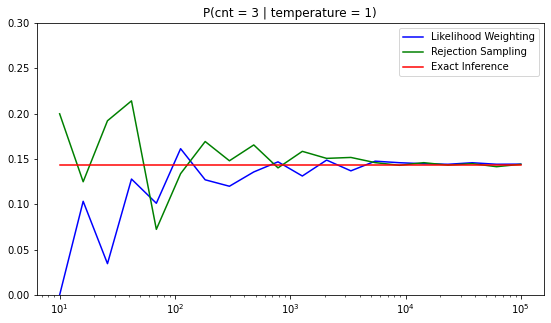

In [90]:
exact_inference = infer_non_adjust.query(variables=["cnt"], evidence = {"temperature": 1}).values[3]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0, 0.3)
plt.title('P(cnt = 3 | temperature = 1)')
LWCplot, = plt.semilogx(np.logspace(1, 5, num=20, dtype="int"), probabilities_lw,'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(np.logspace(1, 5, num=20, dtype="int"), probabilities_rs,'g',label="Rejection Sampling")
VECplot, = plt.semilogx(np.logspace(1, 5, num=20, dtype="int"), exact_inference*np.ones(20),'r',label="Exact Inference")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.show()

In [93]:
# Rejection Sampling
# P(time = evening | cnt = 3, temperature = 1)
evidence = [State("cnt", 3), State("temperature", 1)]
probabilities_rs = []
for size in np.logspace(1, 5, num=20, dtype="int"):
    samples = inference.rejection_sample(evidence = evidence, size = size, show_progress = False)
    probabilities_rs.append(samples[samples['time'] == "evening"].shape[0] / size)

In [94]:
# Likelihood Weighted
# P(time = evening | cnt = 3, temperature = 1)
probabilities_lw = []
for size in np.logspace(1, 5, num=20, dtype="int"):
    samples = inference.likelihood_weighted_sample(evidence = evidence, size = size, show_progress = False)
    probabilities_lw.append(np.dot((samples['time'] == "evening").astype(int),samples['_weight'])/np.sum(samples['_weight']))

Eliminating: weather: 100%|██████████| 7/7 [00:00<00:00, 212.06it/s] 


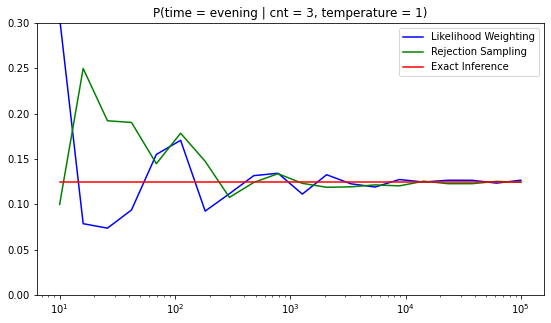

In [100]:
exact_inference = infer_non_adjust.query(variables=["time"], evidence = {"cnt": 3, "temperature": 1}).values[1]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.ylim(0, 0.3)
plt.title('P(time = evening | cnt = 3, temperature = 1)')
LWCplot, = plt.semilogx(np.logspace(1, 5, num=20, dtype="int"), probabilities_lw,'b',label="Likelihood Weighting")
RSCplot, = plt.semilogx(np.logspace(1, 5, num=20, dtype="int"), probabilities_rs,'g',label="Rejection Sampling")
VECplot, = plt.semilogx(np.logspace(1, 5, num=20, dtype="int"), exact_inference*np.ones(20),'r',label="Exact Inference")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.show()